In [1]:
import torch
import matplotlib.pyplot as plt

from Operator import Operator
from solve import solve, measure_uc, measure_mchi, fit

from utils import print_state
from zipdata import MeaData

In [2]:
# 0.1 define `build_CEFparam` function
# below function builds :
#   a[0] * O[2,2] + a[1] * O[2,0]
# + a[2] * O[4,4] + a[3] * O[4,2]
# + a[4] * O[4,0] + a[5] * O[6,6] + a[6] * O[6,4] + a[7] * O[6,2] + a[8] * O[6,0]

def build_CEFparam(a):
    r"""
    build the coefficient for steven operators O[l,m]

    Args:
        a (torch.Tensor): initial parameters to construct

    Returns:
        B2 (torch.Tensor): coefficient for O[2,2],O[2,1],O[2,0],O[2,-1],O[2,-2]
        B4 (torch.Tensor): coefficient for O[4,4],O[4,3],O[4,2],O[4,1],O[4,0],O[4,-1],O[4,-2],O[4,-3],O[4,-4]
        B6 (torch.Tensor): coefficient for O[6,6],O[6,5],O[6,4],O[6,3],O[6,2],O[6,1],O[6,0],O[6,-1],O[6,-2],O[6,-3],O[6,-4],O[6,-5],O[6,-6]
    """
    zero = torch.tensor(0.0)

    B2 = torch.stack([a[0], zero, a[1], zero, zero])
    B4 = torch.stack([a[2], zero, a[3], zero, a[4], zero, zero, zero, zero])
    B6 = torch.stack([a[5], zero, a[6], zero, a[7], zero, a[8], zero, zero, zero, zero, zero, zero])

    return B2, B4, B6

In [3]:
# 0.2 define `build_field` function
# below define a g * \mu_{B} * B^{z}
def build_field(B):
    """
    The function to build H
    default for z-axis
    Args:
        B: the magnetic field

    Returns:
        H: g μB B

    """

    zero = torch.tensor([0.0])
    # g-tensor
    g = torch.tensor([1.0, 1.0, 1.0])
    μB = 1.0

    # x-axis
    # H = torch.cat([B, zero, zero])
    # y-axis
    # H = torch.cat([zero, B, zero])
    # z-axis
    H = torch.cat([zero, zero, B])
    H = μB * g * H
    return H

In [4]:
# 0. set seed
# different seed should be considered
torch.manual_seed(0)

# 1. define steven operators
spin=4.5
op = Operator(spin)

# 2. load experiment data
# cv data
cdata1 = MeaData()
cdata1.read(filename = 'cv-0.00.dat', B0 = 0.0)
# cdata2, cdata3, ... for more data

cdata = (cdata1,)
# cdata = (cdata1, cdata2, cdata3, ...)

# chi data
chidata1 = MeaData()
chidata1.read(filename = 'chi-1.00.dat', B0 = 1.0)
# chidata2, chidata3, ... for more data

chidata = (chidata1,)
# chidata = (chidata1, chidata2, chidata3, ...)


the steven operator for s=4.5 is successfully built


In [5]:
# 3. set the initial parameters, bounds(optional), method(optional) for curve fit
# opt1: give a guess
# a0 = torch.tensor([0.3631, -0.4536, 0.0241, 0.0403, 0.0089, -0.001, 0.0008, 0.0015, -3.94e-5])

# opt2: give a scope, different scale is suggested to try
a0 = 0.01 * (torch.rand(9) - 0.5) # [-0.005, 0.005)

# consider lambda and chi0 correction for magnetic susceptibility
a0 = torch.cat((a0, torch.tensor([0.0]), torch.tensor([0.0])))

# not necessary
# bounds = list(zip(-np.ones(a0.shape[0]), np.ones(a0.shape[0])))
# method='L-BFGS-B'

# 4.1 fit, a function to call `scipy.optimize.minimize`, see more details about it https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
res = fit(a0,
          build_field,
          op,
          build_CEFparam,
          cdata = cdata,
          chidata = chidata,
          weight = 1.0)

# res = fit(a0,
#           build_field,
#           op,
#           build_CEFparam,
#           cdata = cdata,
#           chidata = chidata,
#           weight = 1.0,
#           bounds = bounds,
#           method = method)

# check if the fit succeed
print(res)

# 4.2. obtain the CFT parameters
x = torch.tensor(res.x)

# 4.3. recover the parameters
num = x.shape[0]
a = x[:num-2]
B2, B4, B6 = build_CEFparam(a)
λ = x[-2]
chi0 = x[-1]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0001686100916498055
        x: [-6.732e-04  3.865e-03  9.565e-03 -2.306e-02  1.831e-03
            -3.633e-03  7.873e-04  3.095e-03  1.846e-05 -4.102e-04
            -1.199e-03]
      nit: 136
      jac: [ 2.537e-03  2.919e-03  4.697e-04  6.638e-04  1.997e-02
             8.177e-04  3.947e-02 -3.447e-02 -4.796e-02  2.213e-03
             2.071e-02]
     nfev: 205
     njev: 205
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>


In [12]:
# 5.1. with the optimized parameters, calculate energy and heat specific
kT = cdata1.kT
B0 = cdata1.B0
u, c = measure_uc(op, kT, B0, build_field, B2, B4, B6)

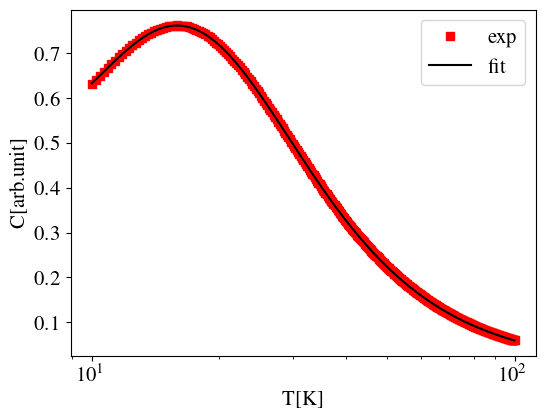

In [13]:
# 5.2. plot
cexp = cdata1.measure
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

plt.semilogx(kT.data, cexp.data, 'rs', label='exp')
plt.semilogx(kT.data, c.data, 'k-', label='fit')
plt.xlabel(r"T[\rm{K}]")
plt.ylabel(r"C[\rm{arb.unit}]")

plt.legend()
plt.show()


In [14]:
# 5.3. with the optimized parameters, calculate magnetization and susceptibility
kT = chidata1.kT
B0 = chidata1.B0
m, chi = measure_mchi(op, kT, B0, build_field, B2, B4, B6)

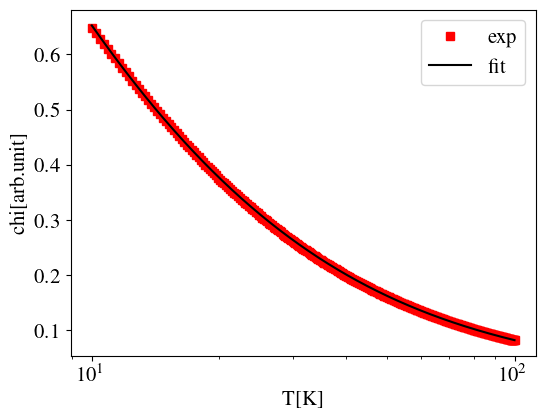

In [15]:
# 5.4. plot
chiexp = chidata1.measure
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

plt.semilogx(kT.data, chiexp.data, 'rs', label='exp')
plt.semilogx(kT.data, chi.data, 'k-', label='fit')
plt.xlabel(r"T[\rm{K}]")
plt.ylabel(r"chi[\rm{arb.unit}]")

plt.legend()
plt.show()


In [16]:
# 6.1. with the optimized parameters, calculate energy levels and associated wave functions
enr, psi = solve(op, build_field(B0), B2, B4, B6)

In [17]:
# 6.2. list the states
N = op.N
print_state(N, enr, psi)
# if the format is not so tidy up, try to copy the output to normal `txt` file

      Eigenvalue       |      |4.5>      |      |4.0>      |      |3.5>      |      |3.0>      |      |2.5>      |      |2.0>      |      |1.5>      |      |1.0>      |      |0.5>      |      |0.0>      |     |-0.5>      |     |-1.0>      |     |-1.5>      |     |-2.0>      |     |-2.5>      |     |-3.0>      |     |-3.5>      |     |-4.0>      |     |-4.5>     
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        0.0000         | -0.1748+0.0000j | -0.0000+0.3957j | -0.1314-0.0000j | -0.0000+0.4524j | +0.3015+0.0000j | +0.0000-0.3015j | -0.4524-0.0000j | -0.0000+0.1314j | -0.3957-0.0000j | -0.0000+0.1748j
        3.8201         | -0.1121-0.0000j | -0.0000-0.4743j | -0.217